# Previsão da Taxa de Crescimento do COVID-19 em Blumenau

- Criado em    : 23/03/2019
- Atualizado em: 01/05/2020
- Autor        : Rodrigo de Lima Oliveira (Unimed Blumenau)

## 1. Fonte de Dados
- Prefeitura de Blumenau

## 2. Preparando o Ambiente

In [1]:
import sys
import warnings
import matplotlib.pyplot as plt
import matplotlib.cbook
from matplotlib.ticker import MaxNLocator

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Bibliotecas padrões
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns
import datetime
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset


sns.set_context('talk')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

# Bibliotecas importantes
import pymc3
import arviz as az
import altair as alt

# Definindo tamanho da saida dos dados em tela
pd.options.display.max_seq_items = 8000
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Unimed-Blumenau" --iversions

altair     4.0.1
matplotlib 3.2.1
numpy      1.18.2
seaborn    0.10.0
arviz      0.7.0
pandas     1.0.3
pymc3      3.8
Unimed-Blumenau


In [3]:
# Defini parametros do arquivo
path        = "../data/"                                   # caminho do diretorio dos dados
file_name   = "lista_pacientes_blumenau_15_05_20.xlsx"     # nome do arquivo base da prefeitura
sheet_name  = "Previsao"                                   # nome da aba dos valores para alimentar o modelo
file_export = "previsoes_blumenau_15_05_20.xlsx"                    # nome do arquivo final com as previsoes
encoding    = "utf8"                                       # tipo de encoding do arquivo

# Definindo parametros para previsao
city          = "Blumenau"                                 # nome da cidade a ser analisada
num_caso_ini  = 98                                         # contar a partir de quantos casos
qtd_dias_prev = 15                                         # quantidade de dias de forecast


## 3. Coletar dados sobre o COVID-19

In [4]:
# Define a função
def coleta_dados():
    
    # Leitura do arquivo de origem
    data = pd.read_excel (path+file_name, sheet_name=sheet_name, encoding=encoding)
    
    # Define os nomes das colunas
    data = data[['DATA','QTDE_POSITIVADO_DIA','QTDE_POSITIVADO_TOTAL']]
    data.columns = ['date', 'newCases', 'totalCases']
    data['date'] = pd.to_datetime(data['date'])

    # Colocando a data como index
    data = data.set_index('date')

    # Busca o número de dias desde o momento em que x casos confirmados foram cruzados
    data['days_since'] = np.nan

    # Marcando registros positivos acima de 'num_caso_ini' casos em Blumenau
    data['days_since'] = np.arange(-len(data[data.totalCases < num_caso_ini]), len(data[data.totalCases >= num_caso_ini]))
    
    return data

# Realizando a coleta dos dados
dados_covid = coleta_dados()

# Selecionando somente a partir de 'num_caso_ini' casos registrados de COVID-19
dados_covid = dados_covid.loc[lambda x: (x.days_since >= 0)]

## 4. Construção do Modelo

In [5]:
# Funcao para criacao do modelo
def create_model():
    
    # Criação do Modelo
    with pymc3.Model() as modelo:

        # Definimos o intercepto
        a_grp = pymc3.Normal('a_grp', 100, 50)
        a_grp_sigma = pymc3.HalfNormal('a_grp_sigma', 50)
        a_ind = pymc3.Normal('a_ind', mu = a_grp, sigma = a_grp_sigma, shape = 1)

        # Definimos o slope
        b_grp = pymc3.Normal('b_grp', 1.33, .5)
        b_grp_sigma = pymc3.HalfNormal('b_grp_sigma', .5)
        b_ind = pymc3.Normal('b_ind', mu = b_grp, sigma = b_grp_sigma, shape = 1)

        # Erro
        sigma = pymc3.HalfNormal('sigma', 500., shape = 1)

        # Criar probabilidades
        x = pymc3.Data(city + "x_data", dados_covid.days_since.values)
        confirmed = pymc3.Data(city + "y_data", dados_covid.totalCases.astype('float64').values)

        # Negative Binomial
        pymc3.NegativeBinomial(city,
                               (a_ind * b_ind ** x), 
                               sigma, 
                               observed = confirmed)
        
    return modelo

# Funcao para realizar as previsoes com base no modelo
def fit_model(modelo):
    with modelo:

        # Amostra posterior
        trace = pymc3.sample(tune = 1500, chains = 1, cores = 1, target_accept = .9, progressbar = True)

        # Atualiza os dados para que possamos obter previsões para o futuro
        x_data = np.arange(0, dados_covid.shape[0] + qtd_dias_prev)
        y_data = np.array([np.nan] * len(x_data))
        pymc3.set_data({city + "x_data": x_data})
        pymc3.set_data({city + "y_data": y_data})

        # Previsão da amostra posterior (100 amostras)
        previsoes = pymc3.sample_posterior_predictive(trace, samples = 100)

    return trace, previsoes

## 5. Execução do Modelo

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, b_ind, b_grp_sigma, b_grp, a_ind, a_grp_sigma, a_grp]
Sampling chain 0, 20 divergences: 100%|██████████| 2000/2000 [00:10<00:00, 190.64it/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
100%|██████████| 100/100 [00:00<00:00, 141.51it/s]


CPU times: user 16 s, sys: 577 ms, total: 16.6 s
Wall time: 18.8 s


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5525d5f90>,
      dtype=object)

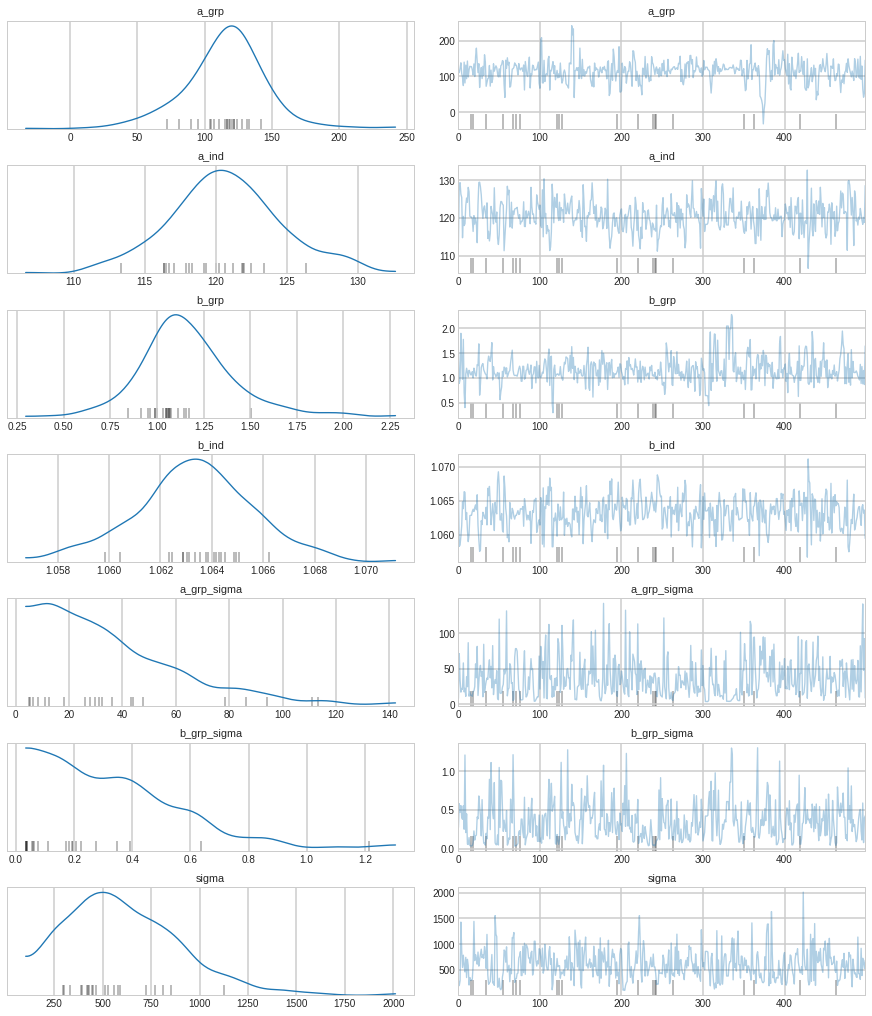

In [6]:
%%time

# Criacao do modelo
model = create_model()

# Realizando as previsoes
trace, previsoes = fit_model(model)

# Avaliação do Modelo
az.plot_trace(trace, compact = True);

## 6. Gráficos

In [7]:
# Funcao para completar as datas futuras
def fill_prev_date(df, fill_value=0):

    idx = pd.date_range(df[0], df[0]+DateOffset(days=df.shape[0]-1),freq='D')
    df = df.reindex(idx, fill_value=fill_value)
    df['date'] = pd.DatetimeIndex(df.index)

    return df

In [8]:
# Renomeando coluna para realizar o merge com as previsoes
dfBlumenauSC = dados_covid.rename(columns={"days_since": "days"})
dfBlumenauSC = dfBlumenauSC.reset_index()

# Convertendo as previsoes para dataframe
pred = previsoes[city].T
df_previsoes = pd.DataFrame(pred)
df_previsoes = df_previsoes.reset_index()
df_previsoes = df_previsoes.rename(columns={"index": "days"})

# Realizando o merge dos dois datasets (como chave o dia)
merge = pd.merge(dfBlumenauSC, df_previsoes, on=['days'], how='right')

# Selecionando apenas a média das 100 probabilidades
col = merge.iloc[:, 4:merge.shape[1]]

# Criando novas colunas para o gráfico
merge['media']       = col.mean(axis = 1)
merge['min']         = col.min(axis = 1) 
merge['max']         = col.max(axis = 1) 

# Ordenando valores para o grafico
merge['media'] = merge['media'].sort_values().values
merge['min'] = merge['min'].sort_values().values
merge['max'] = merge['max'].sort_values().values

# Preenchendo valores nulos
merge['grafico_avg'] = merge['totalCases']
merge['grafico_avg'] = merge['grafico_avg'].fillna(merge['media'])
merge['grafico_min'] = merge['totalCases']
merge['grafico_min'] = merge['grafico_min'].fillna(merge['min'])
merge['grafico_max'] = merge['totalCases']
merge['grafico_max'] = merge['grafico_max'].fillna(merge['max'])

merge[['date','totalCases','media','min','max','grafico_avg','grafico_min','grafico_max']]

# Preenchendo as datas futuras com nulo
new_data = fill_prev_date(df=merge['date'])
merge['date'] = new_data['date']
merge['date'] = merge['date'].dt.strftime('%d-%m-%Y')

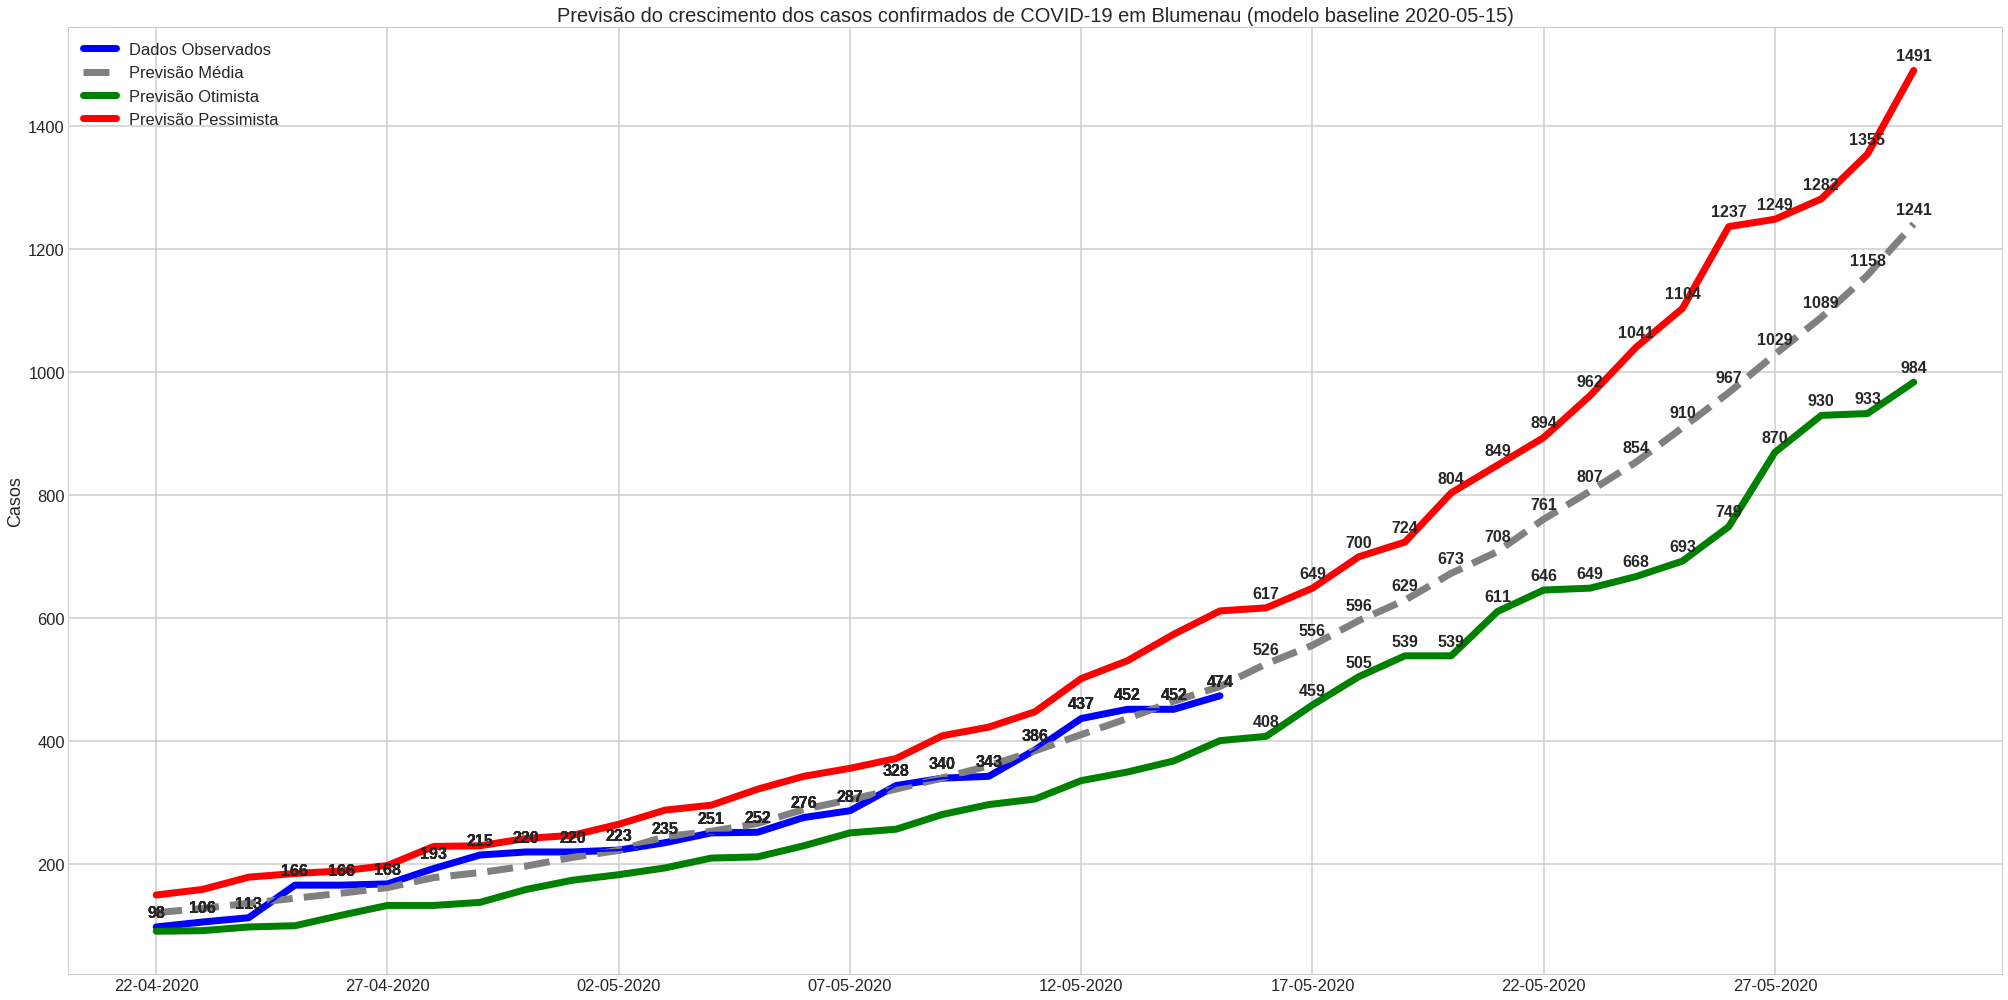

In [9]:
############# EXIBINDO GRÁFICO GERAL ###############
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (28, 14), sharex = True)

ax.plot(merge.date, merge.totalCases, color='b', linewidth=7)
ax.plot(merge.date, merge['media'], alpha = 1, color = '.5', ls = '--', linewidth=7)
ax.plot(merge.date, merge['min'],   alpha = 1, color = 'g', linewidth=7)
ax.plot(merge.date, merge['max'],   alpha = 1, color = 'r', linewidth=7)
#ax.plot(covid_blumenau.date, covid_blumenau['recover'],  color = 'pink')

ax.plot(merge.date, merge.totalCases, color='b')
#ax.set_ylim(0, 650)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Previsão do crescimento dos casos confirmados de COVID-19 em Blumenau (modelo baseline '+str(datetime.now().date())+')', fontsize=20)
ax.legend(['Dados Observados', 'Previsão Média', 'Previsão Otimista', 'Previsão Pessimista'])
ax.set(ylabel = 'Casos')

xs = merge.date

# Valores na linha de casos reais    
ys = merge['totalCases']
for x, y in zip(xs,ys):
    label = "{:.0f}".format(y)
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 weight='bold',
                 fontsize=16,
                 ha='center') 


# Valores na linha de medio    
ys = merge['grafico_avg']
for x, y in zip(xs,ys):
    label = "{:.0f}".format(y)
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 weight='bold',
                 fontsize=16,
                 ha='center') 
    
# Valores na linha de Otimista    
ys = merge['grafico_min']
for x, y in zip(xs,ys):
    label = "{:.0f}".format(y)
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 weight='bold',
                 fontsize=16,
                 ha='center')   

# Valores na linha de Pessimista    
ys = merge['grafico_max']
for x, y in zip(xs,ys):
    label = "{:.0f}".format(y)
    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 weight='bold',
                 fontsize=16,
                 ha='center') 

fig.tight_layout();



## 7. Exportar para Excel

In [10]:
merge.to_excel(path+file_export, index=False)

# Fim